Notebook purpose

- Check whether there is a reliable way to identify savings transactions

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.txn_classifications as tc
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 2.18 seconds
Time for read_sample    : 3.64 minutes
(7,531,116, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,19510816,2014-03-07,107,9.20,paypal sandrpowell 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,NaN,27530.926758,2.036569
1,19510817,2014-03-08,107,6.94,paypal smartbitsso 9001,paypal,spend,services,0.0,gl3 4,2010-05-10,40k to 50k,1984.0,2014-05-11,238820,2020-08-16 12:13:00,barclaycard,credit card,2014-07-18,2017-09-12,True,NaN,paypal,enjoyment,home electronics,home electronics,u,201403,NaN,27530.926758,2.036569


## Tags

The simplest approach to identify savings is to use MDB auto tags. I have grouped all relevant auto tags into a `tag` called *savings*, which is a subgroup of the `tag_group` *transfters*.

In [8]:
tc.transfers_subgroups["savings"]

['general savings',
 'investment - other',
 'investments or shares',
 'isa',
 'pension or investments',
 'saving (general)',
 'savings (general)',
 'savings']

There are not enough txns and users to work with.

In [9]:
savings = df[df.tag.eq("savings")]
hd.txns_and_users(savings, df)

df1 has 19,207 txns across 1176 users (0.3% and 43.3% of df2).


## Savings account transfers

An alternative is to look at flows into and out of savings accounts. We could define something like 'monthly net savings' as the the sum of all inflows and outflows into a users savings accounts during a month.

In [10]:
savings = df[df.account_type.eq("savings")]
credits = savings[~savings.debit]
debits = savings[savings.debit]

There are many more transactions across many more users than for tags above.

In [11]:
hd.txns_and_users(savings, df)

df1 has 163,681 txns across 1557 users (2.2% and 57.3% of df2).


We'd expect credits and, to a lesser extent, debits to mostly be round amounts. The below shows that this is the case (apart from interest payments).

In [18]:
savings.amount.value_counts().iloc[:10]

 100.00    6295
 50.00     5031
-100.00    4247
-200.00    4219
-50.00     3772
 200.00    3714
 20.00     3703
-0.01      3135
 10.00     3062
 30.00     2345
Name: amount, dtype: int64

Most common amounts for current account txns are also round, but so a somewhat lesser extent.

In [19]:
df[df.account_type.eq("current")].amount.value_counts().iloc[:20]

 10.00     159294
 20.00     139760
 50.00      83527
 30.00      80185
 5.00       78094
 100.00     66122
 3.00       57742
 40.00      52543
 7.99       43063
 15.00      42827
 25.00      39636
 2.00       38595
 6.00       38154
 9.99       37906
 200.00     34377
-100.00     32393
 1.00       31999
 4.00       31223
 1.50       28029
-50.00      26300
Name: amount, dtype: int64

Plot distributions of monthly inflows, outflows, and net savings.

In [21]:
def make_data(df):
    def _is_round_amount(x, multiple=5):
        return not x % multiple

    def _get_savings_txns(df):
        """Keeps round savings-account txns."""
        mask = df.account_type.eq("savings") & df.amount.apply(_is_round_amount)
        return df[mask].copy()

    def _agg_inflows_outflows_net(df):
        df["debit"] = df.debit.replace({True: "debit", False: "credit"})
        month = pd.Grouper(key="date", freq="m")
        return (
            df.groupby(["user_id", month, "income", "debit"])
            .amount.sum()
            .abs()
            .unstack()
            .assign(net=lambda df: df.credit - df.debit)
        )

    def _scale_by_monthly_income(df):
        monthly_income = df.index.get_level_values("income") / 12
        scaled_df = df.div(monthly_income, axis="rows")
        return scaled_df.reset_index("income", drop=True)

    def _trim_cols(df, pct=5):
        return df.apply(hd.trim, pct=pct)

    return (
        df.pipe(_get_savings_txns)
        .pipe(_agg_inflows_outflows_net)
        .pipe(_scale_by_monthly_income)
        .pipe(_trim_cols)
    )


def make_figure(df):
    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    fig.suptitle("Monthly savings account transactions")
    ylabel = "User-months (%)"
    for i, col in enumerate(df.columns):
        sns.histplot(x=df[col], stat="percent", ax=ax[i])
        ax[i].set(xlabel=col.title(), ylabel=ylabel)

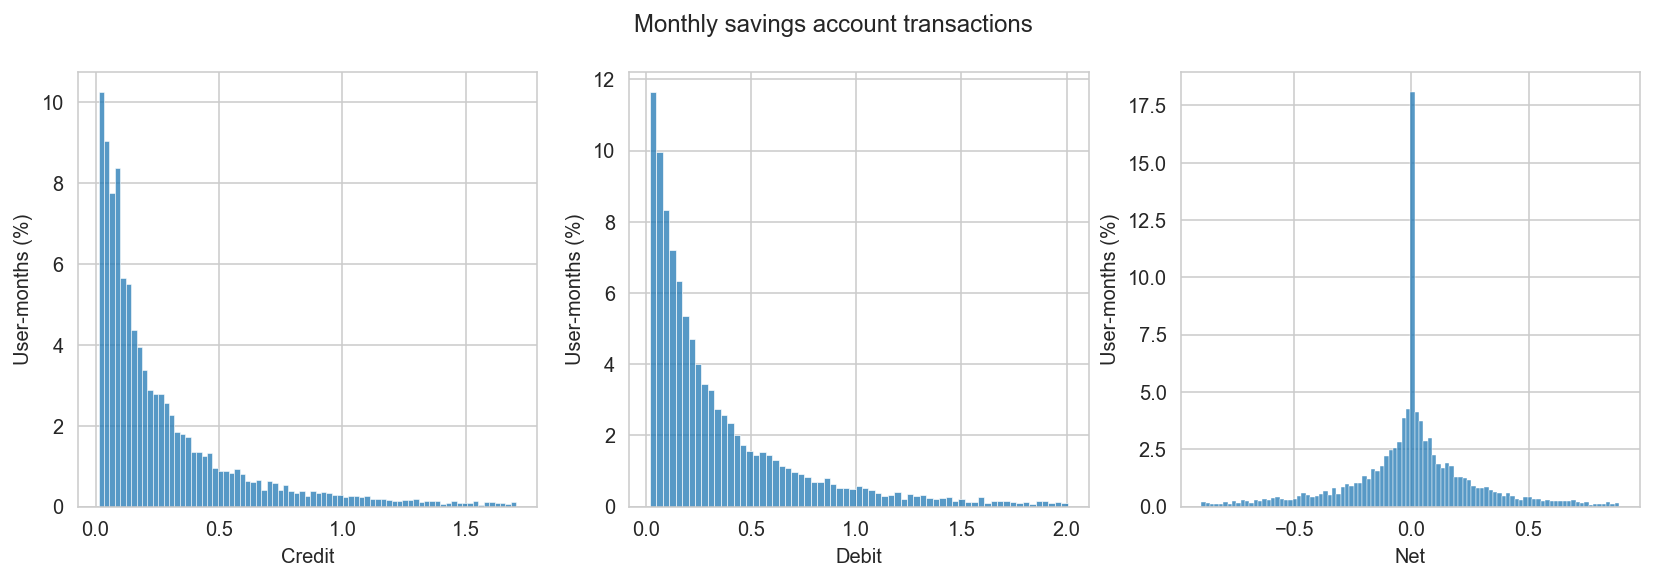

In [22]:
monthly_savings = make_data(df)
make_figure(monthly_savings)

## Non-standing-order transactions only

todo if needed

In [21]:
savings.desc.value_counts()[:5]

mdbremoved                  32161
mdbremoved ft                5186
save the change bp           4713
transfer from mdbremoved     4067
mdbremoved tfr               4049
Name: desc, dtype: int64